In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8779 × 3512
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'medulla_cortex', 'domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'cell_type_int'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [4]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [5]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
# sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

CPU times: user 1min 3s, sys: 6.66 s, total: 1min 10s
Wall time: 52.9 s


In [7]:
%%time

sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

CPU times: user 9.02 s, sys: 2.76 s, total: 11.8 s
Wall time: 5.77 s


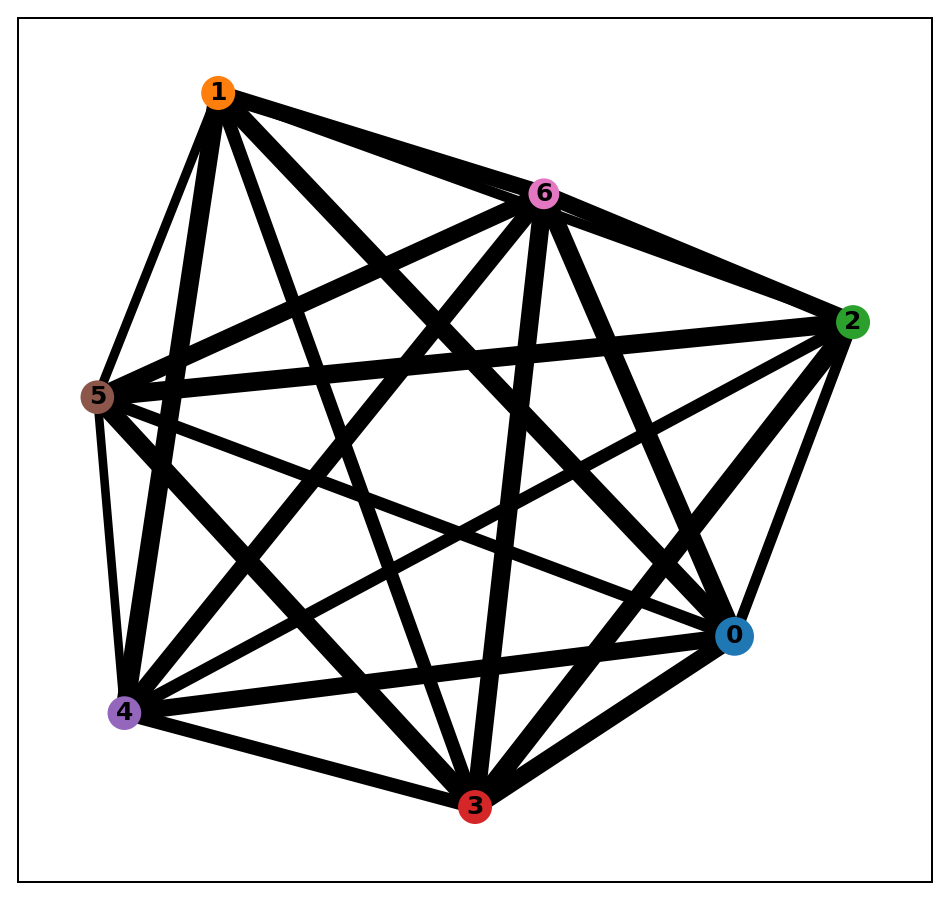

CPU times: user 1.03 s, sys: 447 ms, total: 1.47 s
Wall time: 142 ms


In [8]:
%%time

sc.tl.paga(adata, groups='cell_type')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

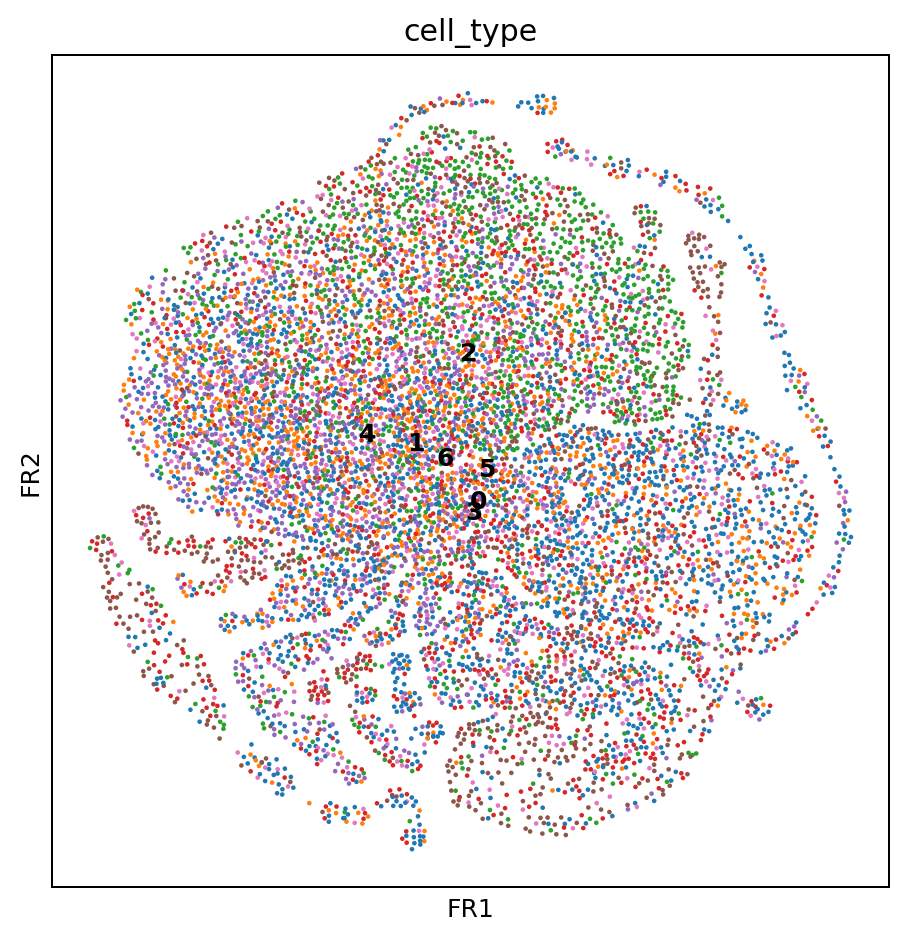

In [9]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data')
plt.show()

In [14]:
adata.layers

Layers with keys: imputed_count, normalized_count, raw_count

In [17]:
adata.X.toarray()

array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., 11.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.]], dtype=float32)

In [18]:
adata.X.max()

10652.0

In [21]:
adata.layers["raw_count"].toarray().max()

10652.0

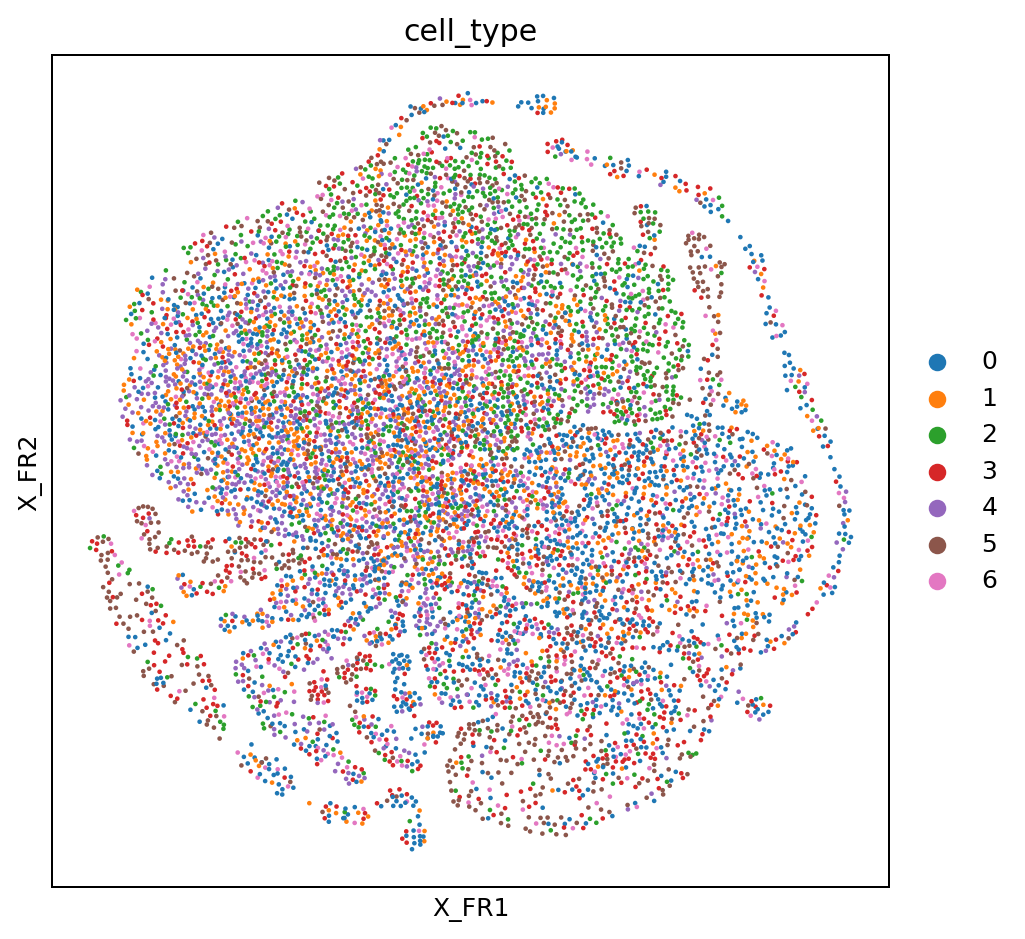

In [22]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_draw_graph_fr"
)

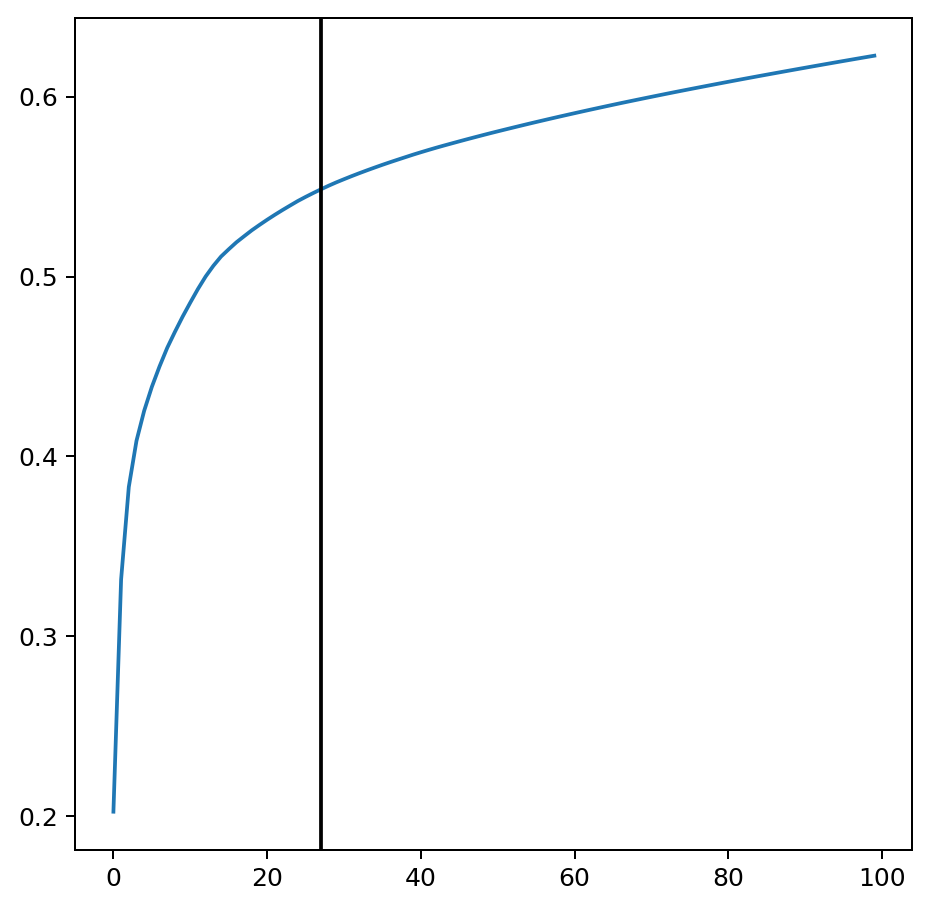

27


In [23]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [24]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :8779
Auto-selected k is :219


In [25]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [26]:
# base_GRN = co.data.load_human_promoter_base_GRN()
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [27]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=10
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/3180 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:21<08:09, 81.66s/it]

Inferring GRN for 1...


  0%|          | 0/3180 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [02:35<06:24, 76.83s/it]

Inferring GRN for 2...


  0%|          | 0/3180 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [03:48<05:00, 75.06s/it]

Inferring GRN for 3...


  0%|          | 0/3180 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [05:02<03:43, 74.63s/it]

Inferring GRN for 4...


  0%|          | 0/3180 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [06:19<02:31, 75.74s/it]

Inferring GRN for 5...


  0%|          | 0/3180 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [07:34<01:15, 75.26s/it]

Inferring GRN for 6...


  0%|          | 0/3180 [00:00<?, ?it/s]

100%|██████████| 7/7 [08:47<00:00, 75.40s/it]

CPU times: user 6min 3s, sys: 22.8 s, total: 6min 25s
Wall time: 8min 48s


In [28]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
import pickle

with open('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

# with open('/Users/koush/Projects/SpaceOracle/data/slidetags/tonsil_celloracle.pkl', 'wb') as f:
#     pickle.dump(oracle, f)

In [30]:
adata

AnnData object with n_obs × n_vars = 8779 × 3512
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'medulla_cortex', 'domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'cell_type_int'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'spatial', 'X_pca', 'X_diffmap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [31]:
{i: k for i, (k,) in enumerate(zip(list(links.links_dict.keys())))}

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}